In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print(data.shape)

(1338, 7)


In [4]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [7]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [8]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [9]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [10]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print(np.round(lr.intercept_, 2))
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

-12390.8
Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


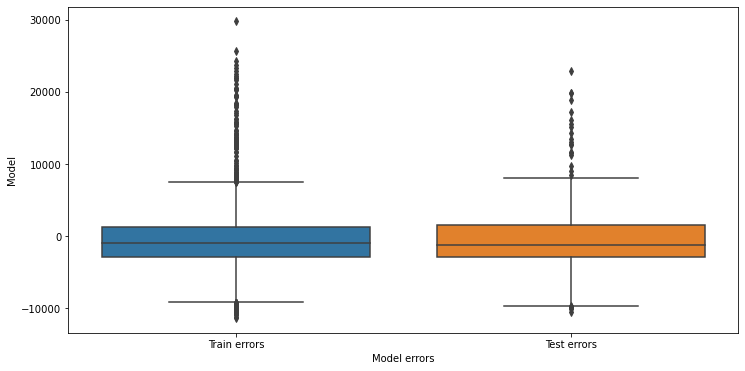

In [11]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [12]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

#Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(1070, 54)
(268, 54)


In [16]:
#Инициализируем объект класса линейная регрессия
lrp = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lrp.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lrp.predict(X_train_scaled_poly)
y_test_pred = lrp.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print(np.round(lrp.intercept_, 2))
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

1.4983634428971194e+17
Train R^2: 0.842
Train MAE: 2902.066
Train MAPE: 29.701


Test R^2: 0.865
Test MAE: 2755.603
Train MAPE: 31.014


In [37]:
# #Составляем таблицу из признаков и их коэффициентов
# w_df = pd.DataFrame({'Features': features, 'Coefficients': lrp.coef_})
# #Составляем строчку таблицы со свободным членом
# intercept_df = pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lrp.intercept_})
# coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
# display(coef_df)

np.concatenate( (np.array([lrp.intercept_]), np.array(lrp.coef_)) )

array([ 1.49836344e+17,  3.29163339e+16, -2.61339125e+16, -1.68066974e+16,
        4.60943562e+16,  6.50932781e+15, -9.02443338e+16, -1.10006135e+17,
       -3.43736567e+16, -8.12969694e+16,  8.75200000e+03,  7.04000000e+02,
        1.40000000e+03, -1.69600000e+03, -2.80000000e+01, -3.29163339e+16,
       -3.29163339e+16, -3.29163339e+16, -3.29163339e+16,  3.62238485e+16,
        5.43000000e+02, -1.17600000e+03,  3.44000000e+02, -1.00899360e+16,
       -1.00899360e+16, -1.00899360e+16, -1.00899360e+16, -9.52000000e+03,
        1.75200000e+03,  5.47210000e+04,  1.68066974e+16,  1.68066974e+16,
        1.68066974e+16,  1.68066974e+16, -2.01600000e+03, -2.32000000e+03,
       -4.60943562e+16, -4.60943562e+16, -4.60943562e+16, -4.60943562e+16,
       -3.72144252e+15, -2.78788528e+15, -2.78788528e+15, -2.78788528e+15,
       -2.78788528e+15, -5.95920105e+16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.98302091e+16,  0.00000000e+00,  0.00000000e+00,
       -1.15462688e+17,  

In [38]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
print(np.concatenate( (np.array([lasso_lr_poly.intercept_]), np.array(lasso_lr_poly.coef_)) ))
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

[ 2.24971352e+03  3.24221653e+03 -4.92313816e+02  5.07612317e+03
  4.58362056e+03  1.97928569e+03  1.88025707e+02 -4.70775218e+02
  5.83657101e+02 -2.43543456e+02  8.29826751e+03  7.74581954e+02
  8.44448593e+02 -1.20775688e+03  1.34809915e+02 -1.04309726e+03
 -0.00000000e+00  1.16964229e+03  1.61765564e+03 -0.00000000e+00
  5.05847740e+02 -1.13425152e+03  2.65796922e+02 -1.22240479e+03
  0.00000000e+00  2.36213242e+02 -5.80031340e+02 -8.17963257e+03
  1.29487768e+03  5.47148553e+04  3.58531873e+03  2.40690210e+03
 -9.63549427e+02  0.00000000e+00 -1.67464337e+03 -2.05436459e+03
  1.94204864e+03  1.95394442e+03 -0.00000000e+00 -1.06364416e+03
  8.00606774e+00  5.93688978e+02 -0.00000000e+00 -2.30643423e+02
  1.97933477e+03  6.31615519e+02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.05849873e-01]
Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 

In [ ]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print(np.concatenate( (np.array([ridge_lr_poly.intercept_]), np.array(ridge_lr_poly.coef_)) ))
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)